In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Students dataset: uses various socio-economic and academic factors to predict exam performance.

In [2]:
df1 = pd.read_csv('student-mat.csv', sep = ';')
df2 = pd.read_csv('student-por.csv', sep = ';')

In [3]:
df1.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [4]:
#Look at missing values
#df1.isna().sum()
#No missing values

In [5]:
df1.shape

(395, 33)

In [6]:
#Look at distribution of grades
#import matplotlib.pyplot as plt
#plt.hist(df1['G3']) #Looks normal, with mean slightly greater than 10 and not much in the lowest ranges

In [7]:
df1.dtypes

school        object
sex           object
age            int64
address       object
famsize       object
Pstatus       object
Medu           int64
Fedu           int64
Mjob          object
Fjob          object
reason        object
guardian      object
traveltime     int64
studytime      int64
failures       int64
schoolsup     object
famsup        object
paid          object
activities    object
nursery       object
higher        object
internet      object
romantic      object
famrel         int64
freetime       int64
goout          int64
Dalc           int64
Walc           int64
health         int64
absences       int64
G1             int64
G2             int64
G3             int64
dtype: object

In [8]:
#Convert categorical data
cat_cols = df1.select_dtypes(exclude = 'int64')
df1_processed = pd.get_dummies(df1, columns = cat_cols.columns, drop_first = True)
df1_processed.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,1,0,1,0,0,0,1,1,0,0
1,17,1,1,1,2,0,5,3,3,1,...,0,0,0,1,0,0,0,1,1,0
2,15,1,1,1,2,3,4,3,2,2,...,1,0,1,0,1,0,1,1,1,0
3,15,4,2,1,3,0,3,2,2,1,...,1,0,0,1,1,1,1,1,1,1
4,16,3,3,1,2,0,4,3,2,1,...,0,0,0,1,1,0,1,1,0,0


In [9]:
print(df1_processed.columns)

Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2',
       'G3', 'school_MS', 'sex_M', 'address_U', 'famsize_LE3', 'Pstatus_T',
       'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher',
       'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher',
       'reason_home', 'reason_other', 'reason_reputation', 'guardian_mother',
       'guardian_other', 'schoolsup_yes', 'famsup_yes', 'paid_yes',
       'activities_yes', 'nursery_yes', 'higher_yes', 'internet_yes',
       'romantic_yes'],
      dtype='object')


In [25]:
from sklearn.model_selection import train_test_split
X = df1_processed.drop(['G1', 'G2', 'G3'], axis = 1)
y = df1_processed['G3']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

We first try fitting a simple decision tree to the data.

In [26]:
#Simple decision tree
from sklearn.tree import DecisionTreeRegressor
tr1 = DecisionTreeRegressor()
tr1.fit(X_train, y_train)
print('Train score: ', tr1.score(X_train, y_train))
print('Test score: ', tr1.score(X_test, y_test))

Train score:  1.0
Test score:  -0.5946567392970545


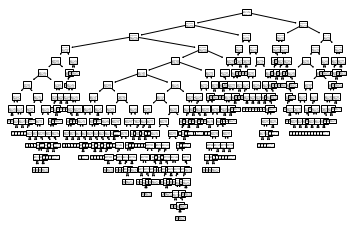

In [94]:
#Clearly overfitting.
from sklearn.tree import plot_tree
plot_tree(tr1)
plt.show()

In [28]:
#Pruning
alphas = set(tr1.cost_complexity_pruning_path(X_train, y_train)['ccp_alphas'])
#Use 5-fold cross-validation to determine mean squared error for each alpha
from sklearn.model_selection import cross_val_score
scores = []
max_score = -100
max_alpha = 0
max_tree = 0
for alpha in alphas:
    total = 0
    tree = DecisionTreeRegressor(ccp_alpha = alpha)
    r_sq = np.mean(cross_val_score(tree, X_train, y_train, cv = 5))
    scores.append([alpha, r_sq])
    if (r_sq > max_score):
        max_score = r_sq
        max_alpha = alpha
        max_tree = tree
print(max_score, max_alpha)

0.15895662317234827 0.7571816761628458


We get a positive score (which is not too low!). Let's look at the tree.

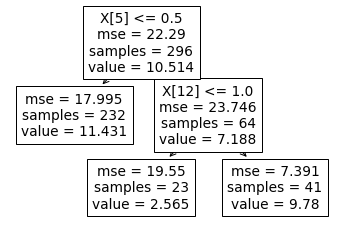

In [29]:
from sklearn.tree import plot_tree
max_tree.fit(X_train, y_train)
plt.Figure(figsize = (50, 50))
plot_tree(max_tree)
plt.savefig('tree.png')

The first split is based on the number of failures in class, which is certainly sensible. Although would this be too much of a giveaway for us to include it among the features? The second level is absences (12) (more absences indicate a higher score!). Slightly weird.

In [30]:
max_tree.score(X_test, y_test) #We get a positive score for test set, which is even higher than cross-validation. Weird.

0.1749606863379961

In [32]:
max_tree.score(X_train, y_train) #There is a bit of overfitting here.

0.25316558270550993

In [33]:
#Just to make the next cell easier
X_train = X_train.reset_index().drop('index', axis = 1)
y_train = y_train.reset_index().drop('index', axis = 1)

In [34]:
print(X_train)
print(y_train)

     age  Medu  Fedu  traveltime  studytime  failures  famrel  freetime  \
0     16     3     3           1          3         0       5         3   
1     15     4     2           1          1         0       2         2   
2     16     4     4           1          2         0       4         1   
3     18     4     3           1          3         0       5         4   
4     16     3     1           1          1         0       5         3   
..   ...   ...   ...         ...        ...       ...     ...       ...   
291   17     2     2           1          1         0       5         3   
292   17     1     1           2          1         1       4         4   
293   15     1     1           1          2         2       3         3   
294   16     3     2           2          3         0       5         3   
295   16     4     4           2          3         0       2         4   

     goout  Dalc  ...  guardian_mother  guardian_other  schoolsup_yes  \
0        3     1  ...     

We now try bagging, which is aggregating the results from many decision trees. For each decision tree, we train it on a sample with replacement of size len(df). 

In [50]:
from sklearn.metrics import r2_score
#Bagging
train_errors = []
oob_errors = []
test_errors = []
size = X_train.shape[0]
best_model2 = []
max_r2 = 0

for B in range(1, 101):
    test_predictions = np.zeros(X_test.shape[0], dtype = np.float32)
    oob_predictions = np.zeros(X_train.shape[0], dtype = np.float32)
    oob_count = np.zeros(X_train.shape[0], dtype = np.float32)
    train_predictions = np.zeros(X_train.shape[0], dtype = np.float32)
    
    trees = []
    for i in range(B):
        #take random sample of dataframe
        X_bag = X_train.sample(n = size, replace = True)
        y_bag = y_train.loc[X_bag.index, :]
        #train decision tree
        tr2 = DecisionTreeRegressor()
        tr2.fit(X_bag, y_bag)
        #Predict train set
        train_predictions += tr2.predict(X_train)
        #Predict oob and test set
        indicator_fn = np.ones(len(X_train.index)) - np.isin(X_train.index, X_bag.index)
        oob_count += indicator_fn
        oob_predictions += indicator_fn * tr2.predict(X_train)
        
        test_predictions += tr2.predict(X_test)
        trees.append(tr2)

    #Calculate r^2 error
    train_predictions /= B
    train_error = r2_score(y_train, train_predictions)
    train_errors.append(train_error)
    
    #Annoying stuff -- need to ignore those which are never out-of-bag.
    nonzero_oob_pred = oob_predictions[oob_count != 0]
    nonzero_oob_count = oob_count[oob_count != 0]
    nonzero_y = y_train[oob_count != 0]
    nonzero_oob_pred /= nonzero_oob_count
    oob_error = r2_score(nonzero_y, nonzero_oob_pred) 
    oob_errors.append(oob_error)
    
    if (oob_error > max_r2):
        max_r2 = oob_error
        best_model2 = trees
    
    test_predictions /= B
    test_error = r2_score(y_test, test_predictions)
    test_errors.append(test_error)
    print(test_predictions)
print(y_test)

[ 0. 15. 13.  0. 16.  7. 15. 10.  8. 10.  0.  9.  8.  7.  0. 11. 14.  6.
 14. 14.  7.  0. 10. 16. 10. 10. 10. 12. 14. 13.  8. 10.  0. 20. 15. 15.
 10.  0.  8. 16. 11. 14. 18.  0. 10.  7. 14. 10. 16. 14.  7.  0. 12. 11.
  6. 11. 11.  0. 12.  0.  0.  0.  0.  6. 12. 15. 14. 15. 11.  8. 14. 13.
 11. 18. 10. 12. 11. 15. 15. 15.  8.  8. 12.  6. 10. 14. 10. 11. 15. 13.
 18. 18. 12.  0. 16. 11. 10. 18.  0.]
[ 0.  11.   6.5  4.5  4.5 10.5 12.  10.5 12.  16.  14.   9.5  8.   5.5
  7.  16.  11.5 11.5 13.  11.  11.5  9.   4.5 15.  15.5  8.5 14.  11.
 12.  11.  10.5 13.  12.  12.5 11.5  6.5  5.5 10.5  7.5  9.5  9.5  5.5
 16.  11.  10.  13.   9.5  8.5 13.5  9.   6.5  6.5 13.5  8.5  9.5 14.5
 11.5 11.   9.   0.   7.   0.  11.   9.5 13.5 10.5 15.  11.5 11.5  5.
 11.  10.  13.  13.5  9.5 14.  15.5 11.5 11.5 11.5  5.5  9.5 11.5  7.5
 10.  10.  10.5  9.5 13.   9.5  6.5  6.  11.   9.   6.  13.   0.   6.5
  5.5]
[ 0.         9.         7.6666665  9.         0.        12.
  5.3333335  8.        12.666667  1

[ 1.6666666 10.         8.416667  10.75       7.9166665 10.333333
 11.5       12.166667   9.666667  11.666667  11.083333   9.416667
 10.083333   8.666667  10.416667  12.916667  14.333333  12.916667
 10.583333  11.        10.75      10.333333   9.583333  12.833333
 11.5       12.166667  12.166667   9.666667  11.5       11.
  9.583333  13.25       7.0833335 14.083333  12.        12.166667
 11.5        7.0833335 10.583333  10.25      10.75      12.166667
 13.166667   6.5       11.916667  12.166667  12.833333  11.25
 13.416667   9.         8.666667   9.666667  10.        11.083333
 11.916667   9.25      10.5       11.416667  10.666667   1.9166666
  1.         7.25       6.0833335  9.166667  11.416667  12.25
 13.5       11.416667  10.583333  13.75      11.5       10.083333
  9.75      13.416667  10.416667  10.        11.833333  14.5
  9.333333  10.833333  10.75      11.5       11.083333   9.416667
 12.083333   9.833333   8.25      12.333333  10.5       10.
 14.5       10.25      10.75      

[ 1.    9.65 10.65 10.6   6.7   9.75  8.9  11.55 11.4  13.25  9.4   8.5
  9.9   8.35 10.4  11.8  11.55 12.7  10.   10.35 10.55 10.85 10.2  13.05
 11.7   9.85 11.5  11.15 11.25 10.65  9.4  11.4   8.35 13.95 11.2   9.65
  9.95  9.2   9.8  10.6  11.2  10.05 10.25  8.65 11.85 13.2  11.35 12.15
 11.45  9.45  9.2   8.7   9.15 11.1  12.5  11.95 12.45  9.75  9.95  3.
  1.8   7.05  7.45 10.45 11.25  9.85 11.3   7.4  11.85  8.3   9.8  10.1
 10.3  13.5  12.5  11.65  8.35 14.75 11.25 10.35  8.85 13.1  11.    9.1
 11.25 10.15 11.3  10.7  11.   10.7  13.55 11.25  9.85  9.45 13.15  8.45
 10.85 11.8   7.45]
[ 1.4285715  9.476191   9.047619  10.809524   8.428572   9.190476
  8.571428  11.190476  11.714286  12.571428  10.238095   8.428572
 10.333333   9.         9.285714  12.809524  12.761905  11.428572
 11.666667  10.666667  10.619047  10.428572   9.        11.476191
 11.523809   8.857142  11.714286   8.809524  11.523809  10.523809
  9.095238  13.095238   7.904762  12.904762  11.714286   8.190476
 12.1

[ 1.7241379 10.827586   9.75862   11.103448   7.37931   10.068966
  9.034483  11.034483  11.5172415 12.103448   9.620689   8.793103
 10.103448   8.310345   8.827586  12.689655  12.034483  12.413794
  9.793103  10.75862   11.724138   9.24138    8.931034  11.793103
 11.24138   10.103448  12.068966  10.137931  12.103448   9.793103
 10.724138  11.896552   7.37931   13.103448  10.75862    9.793103
 11.620689  10.172414   9.586206  11.344828  12.103448  11.827586
 10.586206   7.275862  10.413794  13.655172  10.551724  10.862069
 11.655172   8.862069   8.931034   7.448276   7.206897   9.655172
 11.310345  10.724138  10.310345   9.931034  10.344828   4.862069
  1.9310344  7.8965516  7.448276   8.103448  14.172414   9.5172415
 13.137931  10.724138  11.4827585 10.137931  11.206897  10.068966
 10.827586  11.551724   9.965517  11.172414  10.        14.103448
 10.586206  10.862069   9.551724  12.275862  11.034483   8.586206
 11.931034  10.586206  10.551724  11.896552  11.275862  10.206897
 15.34482

[ 3.162162  10.081081  10.486486  10.216216   7.5945945 10.513514
  9.378378  11.540541  11.567568  11.054054  11.945946   9.027027
  9.1081085  8.918919   9.567568  12.2972975 13.216216  11.675675
 11.162162  11.8918915 10.405405   9.837838  10.2972975 12.135135
 11.918919   9.216216  10.918919   9.945946  11.378378  11.054054
 10.810811  12.540541   7.5675673 13.675675  11.162162  10.
 11.783784  10.540541   8.7027025 12.243243  10.7027025 11.783784
 10.7027025  7.1621623 11.540541  11.945946  11.945946  11.2972975
 11.1081085 10.486486   9.1081085 10.351352  11.        10.189189
 10.324325  11.486486  11.837838  11.        11.513514   3.6756756
  1.5945946  6.7297297  6.5405407 11.459459  14.        10.7027025
 13.567568  11.243243  10.675675  10.432432  11.         9.621622
 11.756757  13.864865  10.621622  10.918919   9.72973   13.675675
 10.486486  10.162162   9.135135  11.810811  10.567568   9.972973
 12.081081   9.621622  11.135135  12.378378  11.945946   9.72973
 15.1081085 12

[ 2.1555555 10.111111   9.088889  10.688889   9.4       10.
  8.044444  11.622222  10.844444  11.466666  11.355556   9.444445
  9.888889   9.822222   8.733334  11.333333  12.111111  12.288889
 10.222222  11.688889  10.933333   9.955556  10.266666  10.9777775
 11.711111   9.9777775 11.133333   8.933333  11.511111  10.733334
  9.822222  12.733334   9.133333  13.355556  11.222222   9.444445
 10.311111  10.         9.422222  11.666667  10.4       11.955556
  9.4        8.        12.133333  12.466666  10.555555  12.133333
  9.377778   9.622222   8.933333   8.377778   8.9777775 10.911111
 10.488889  11.688889   9.688889  10.622222  10.755555   3.1777778
  1.4666667  5.911111   6.2        9.577778  13.8       10.577778
 11.088889   9.866667  10.6       10.155556  11.355556   9.933333
  9.9777775 13.333333   9.888889  10.866667   9.9777775 13.777778
  9.933333  11.822222   7.8444443 12.577778  10.755555   8.244445
 11.466666  10.711111  11.222222  12.333333  11.911111  11.133333
 14.733334  10

[ 2.6981132 10.943397   8.886792  10.396227   7.264151   9.849056
  9.433962  12.075472  11.54717   11.45283   10.245283   8.886792
  9.622642   8.566038   9.132075  12.169811  12.207547  11.471698
  9.867925  10.245283  11.0188675 10.603773   8.9811325 12.45283
 12.0188675 10.        11.113208  10.245283  12.226415  10.566038
  9.584906  11.264151   8.886792  13.622642  11.264151   9.132075
 11.113208   9.226415   9.113208  11.962264  11.075472  11.924528
 10.754717   9.301887  11.490566  10.754717  11.830189  10.9811325
 11.301887   9.943397   9.056603   9.528302   9.490566  10.54717
 11.283019  10.566038  10.81132    9.528302  10.075472   3.6415095
  2.0754716  6.283019   7.3396225  8.490566  13.094339  10.490566
 12.0188675  9.9811325 10.754717  10.0188675 10.962264  10.679245
 11.377358  13.603773  10.905661  10.679245   9.226415  13.320755
 10.679245  10.094339   9.113208  11.584906  11.433962   8.773585
 12.264151  10.        11.415094  11.433962  10.056603   9.905661
 15.226415

[ 1.8852459 10.04918    8.967213  10.983606   8.967213   9.655738
  9.459017  11.540983  11.622951  12.442623  11.4262295  9.393442
 10.196721   9.311476   8.4262295 12.065574  13.147541  12.180327
 10.737705  10.901639  11.147541  10.557377   9.590164  13.147541
 11.4262295 10.327868  11.606558   8.491803  11.213115   9.442623
  9.491803  11.901639   8.262295  14.409836  11.262295  10.131147
 11.590164   9.983606   9.262295  11.639344  11.393442  11.4262295
 10.852459   8.360656  11.295082  11.721312  10.557377  11.557377
 11.590164   9.786885   9.114754   9.459017   7.704918  11.4262295
 12.442623  11.016394  11.065574  10.836065  10.754098   3.7213116
  1.7704918  7.2131147  6.9344263  8.918033  12.672132  11.016394
 12.442623  10.065574  10.540983  10.213115  10.459017  10.852459
 10.655738  13.196721  10.032787  10.721312  10.868853  13.344262
 10.459017  10.098361  11.147541  12.4262295 11.622951   8.737705
 12.180327  10.262295  11.934426  11.5245905 10.606558  10.590164
 15.491

[ 1.8405797 10.144928   9.753623  10.072464   9.101449  10.275362
  9.608696  12.434783  11.971014  11.666667   9.710145   9.217391
  9.927536   8.608696   9.797101  11.898551  12.173913  12.231884
 11.333333  11.043478  10.855072  10.115942   9.797101  12.028986
 11.086957  10.130435  11.956522   9.521739  11.405797  10.797101
 10.231884  12.289855   8.811594  13.028986  11.710145   9.797101
 11.275362   9.492754   9.826087  11.304348  10.73913   12.42029
 11.666667   8.594203  10.927536  12.855072  11.565217  10.724638
 11.985507   9.42029    9.84058    8.884058   8.507246  10.811594
 11.42029   10.550725  10.927536  11.217391  10.391304   3.8985507
  2.1594203  7.1594205  6.3768115  8.681159  13.15942   10.362319
 11.463768  10.652174  11.086957  11.043478  11.652174  10.550725
 11.637681  13.072464  10.362319  11.463768  10.057971  13.971014
  9.913043  10.492754  10.536232  12.956522  11.434783   8.478261
 12.057971  10.318841  10.869565  12.173913  11.913043  10.144928
 14.652174

[ 1.7532468 11.012987  10.038961   9.493506   8.207792   9.74026
  8.896104  11.272727  11.454545  11.727273   9.688312   9.701299
  9.779221   8.857142  10.077922  12.298701  13.051948  11.805195
 11.337663  11.428572  11.597403  10.142858   9.480519  12.896104
 11.584415   9.805195  12.922078  10.168831  11.818182  10.493506
 10.051948  11.987013   8.909091  13.974026  11.207792   9.597403
 12.051948   9.337663   9.662337  12.064935  11.298701  12.116883
 11.233767   9.116883  11.38961   12.519481  11.142858  11.337663
 10.805195   9.298701   9.116883   7.012987   9.285714  10.883117
 11.246754  10.727273  10.077922  10.        10.454545   3.961039
  1.7792208  6.142857   6.5194807  9.        13.636364  10.623377
 12.051948  10.545455  10.792208  10.623377  11.337663  10.909091
 11.168831  13.961039  10.935065  10.428572  10.792208  13.623377
  9.935065  11.233767  11.142858  12.831169  11.441559   8.324676
 12.519481  10.883117  11.831169  11.922078  12.415585   9.831169
 14.220779 

[ 1.8235294  9.976471   9.623529  10.070588   8.682353  10.211764
  9.211764  11.764706  11.376471  11.6470585 10.3294115  9.364706
  9.635294   9.270588   9.023529  11.905882  12.682353  11.717647
 10.917647  11.117647  11.211764  10.6470585 10.470589  11.917647
 11.529411   9.941176  12.6470585  9.294118  11.3294115 10.047059
 10.22353   11.858824   7.7058825 13.341176  11.729412   9.929412
 10.57647    9.235294   9.517647  12.341176  10.870588  12.164706
 10.658824   8.023529  11.258823  12.729412  11.458823  10.494118
 10.22353    9.764706   9.564706   9.2        8.811765  10.070588
 11.247059  11.376471  10.729412  10.964705  10.835294   2.4117646
  2.1882353  7.152941   8.458823   9.058824  13.058824  10.282353
 11.729412  10.552941  11.588235  11.258823  11.023529  10.694118
 11.211764  13.388235  11.176471  10.870588  10.494118  13.494118
 10.364706  10.752941  10.070588  12.564706  10.764706   8.6
 11.788236  10.282353  11.894117  12.211764  11.094118  10.764706
 15.070588  11

[ 1.2258065 10.83871    8.903226  10.258064   8.419354   9.698925
 10.010753  12.010753  11.903226  11.634409  10.354838   9.8494625
  9.72043    8.817204   9.311828  12.193548  12.741936  12.430107
 10.548388  10.870968  11.118279  10.290322   9.365591  12.107527
 11.064516  10.301075  11.731183   9.473118  10.924731  10.580646
 10.881721  12.688172   8.333333  14.1505375 11.129032  10.688172
 10.537635   9.548388   9.741936  12.107527  10.44086   11.526882
 10.032258   8.290322  11.010753  12.086021  11.225806  10.709678
 10.4838705  9.924731   9.225806   9.365591   8.602151  10.1505375
 11.473118  10.548388  10.602151  10.8494625 10.301075   4.612903
  1.7634408  7.0752687  7.032258   8.870968  13.107527  10.688172
 12.473118   9.526882  11.1505375 10.139785  11.67742   10.172043
 10.365591  12.935484  10.623656  11.494623   9.72043   13.505377
 10.27957   11.956989   9.741936  12.408602  11.354838   9.548388
 11.666667  10.010753  11.612904  11.72043   11.580646  10.225806
 15.0860

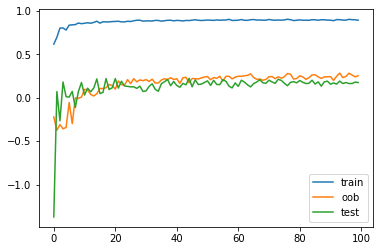

Max test r^2 score:  0.22405089022833669


In [51]:
#See r^2 values for train, oob and test
plt.Figure()
plt.plot(train_errors, label = 'train')
plt.plot(oob_errors, label = 'oob')
plt.plot(test_errors, label = 'test')
plt.legend()
plt.show()
print('Max test r^2 score: ', np.max(test_errors))

This is much better than the pruning and raw decision tree above: test and oob r^2 lies at around 0.2 or higher. Also note oob score is a good estimate of test set score, particularly as B gets large. Let's try using the whole dataset for training and looking only at oob r^2 for model evaluation.

In [52]:
#Bagging
train_errors2 = []
oob_errors2 = []
size = X.shape[0]
best_model = []
max_r2 = 0
for B in range(1, 101):
    oob_predictions = np.zeros(X.shape[0])
    oob_count = np.zeros(X.shape[0])
    train_predictions = np.zeros(X.shape[0])
    trees = []
    for i in range(B):
        #take random sample of dataframe
        X_bag = X.sample(n = size, replace = True)
        y_bag = y.loc[X_bag.index]
        #train decision tree
        tr2 = DecisionTreeRegressor()
        tr2.fit(X_bag, y_bag)
        #Predict train set
        train_predictions += tr2.predict(X)
        #Predict oob and test set
        indicator_fn = np.ones(len(X.index)) - np.isin(X.index, X_bag.index)
        oob_count += indicator_fn
        oob_predictions += indicator_fn * tr2.predict(X)
        trees.append(tr2)

    #Calculate r^2 error
    train_predictions /= B
    train_error = r2_score(y, train_predictions)
    train_errors2.append(train_error)
    
    #Annoying stuff -- need to ignore those which are never out-of-bag.
    nonzero_oob_pred = oob_predictions[oob_count != 0]
    nonzero_oob_count = oob_count[oob_count != 0]
    nonzero_y = y[oob_count != 0]
    nonzero_oob_pred /= nonzero_oob_count
    oob_error = r2_score(nonzero_y, nonzero_oob_pred) 
    oob_errors2.append(oob_error)
    if (oob_error > max_r2):
        max_r2 = oob_error
        best_model = trees

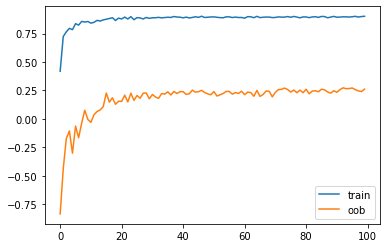

Max oob r^2 score:  0.2734351724679588


In [53]:
#See r^2 values for train and oob
plt.Figure()
plt.plot(train_errors2, label = 'train')
plt.plot(oob_errors2, label = 'oob')
plt.legend()
plt.show()
print('Max oob r^2 score: ', np.max(oob_errors2))

We get a slightly higher value. :)

A disadvantage of bagging is that it is harder to interpret. We try to address this issue by looking at the importance of each feature, in overall. The measure in scikit-learn for this is feature_importance, which measures the total reduction in Gini impurity (p*(1-p)) for each feature. We average this across all the trees.

age                  18.307281
Medu                 13.368131
Fedu                  4.264123
traveltime            3.925490
studytime             3.318454
failures              3.200274
famrel                3.128354
freetime              2.991593
goout                 2.965234
Dalc                  2.872372
Walc                  2.603482
health                2.561617
absences              2.557811
school_MS             2.138602
sex_M                 1.679255
address_U             1.510744
famsize_LE3           1.510614
Pstatus_T             1.356648
Mjob_health           1.310356
Mjob_other            1.307627
Mjob_services         1.216288
Mjob_teacher          1.163609
Fjob_health           1.112884
Fjob_other            1.105017
Fjob_services         1.064621
Fjob_teacher          1.061540
reason_home           1.053536
reason_other          1.043073
reason_reputation     0.984993
guardian_mother       0.844397
guardian_other        0.808179
schoolsup_yes         0.785164
famsup_y

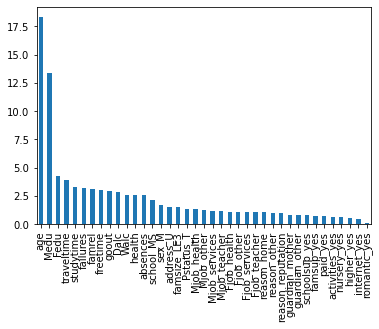

In [54]:
importances = np.zeros(X.shape[1])
for i in best_model:
    importances += i.feature_importances_
sorted_importances = sorted(importances, reverse = True)
bagging_importances = pd.Series(sorted_importances, index=X.columns)
print(bagging_importances)
plt.Figure()
bagging_importances.plot.bar()
plt.show()

Surprisingly, age seems to be the most important factor, followed by mother and father education. This could because age takes on more possible values (8) then the other features (2-5). This is also flagged up on the scikit-learn website. We try permutation importance instead, as suggested by scikit-learn. This randomly permutes each column multiple times, and calculates the mean decrease in R^2 score.

In [55]:
#To use the permutation importance function we train an sklearn model
from sklearn.ensemble import BaggingRegressor
B = np.argmax(oob_errors) + 1
print(B)
br = BaggingRegressor(n_estimators = B)
br.fit(X_train, np.ravel(y_train))
from sklearn.inspection import permutation_importance
r = permutation_importance(br, X_test, np.ravel(y_test), n_repeats = 30, random_state = 1)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X.columns[i]:<15}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

94
failures       0.294 +/- 0.114
absences       0.265 +/- 0.082


We see that number of absences and failures are by far the most important features.

Now we try random forests. This is where for each decision tree, we only select a small fraction of the features (typically sqrt(p)). This is to reduce the correlation between trees, so that aggregating them reduces variance.

In [56]:
from sklearn.ensemble import RandomForestRegressor
train_errors3 = []
oob_errors3 = []
test_errors3 = []
best_model3 = []
highest_oob = 0
for B in range(10, 101):
    rf = RandomForestRegressor(max_features = 'sqrt', n_estimators = B, oob_score = True)
    rf.fit(X_train, np.ravel(y_train))
    train_errors3.append(rf.score(X_train, y_train))
    oob_errors3.append(rf.oob_score_)
    test_errors3.append(rf.score(X_test, y_test))
    if (rf.oob_score_ > highest_oob):
        highest_oob = rf.oob_score_
        best_model3 = rf

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


103
Max oob r^2: 0.2841840084430214
Max test r^2: 0.22405089022833669


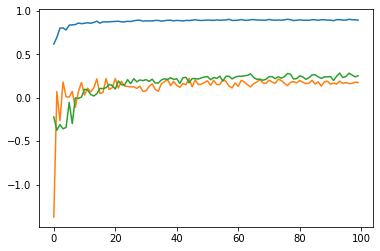

In [57]:
print(np.argmax(oob_errors)+10)
plt.Figure()
plt.plot(train_errors, label = 'train')
plt.plot(test_errors, label = 'test')
plt.plot(oob_errors, label = 'oob')
print('Max oob r^2:', np.max(oob_errors))
print('Max test r^2:', np.max(test_errors))

This yields a similar result to bagging.

In [58]:
from sklearn.inspection import permutation_importance
r = permutation_importance(best_model3, X_test, np.ravel(y_test), n_repeats = 30, random_state = 1)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X.columns[i]:<15}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

absences       0.153 +/- 0.038
failures       0.117 +/- 0.048
goout          0.032 +/- 0.012
activities_yes 0.023 +/- 0.010


Again we see absences and failures stick out, as expected.

Let's compare the mean squared error for the bagging and random forest models. (since the test set is the same)

In [87]:
from sklearn.metrics import mean_squared_error
pred = np.zeros(len(X_test), dtype = np.float32)
for i in best_model2:
    pred += i.predict(X_test)
pred /= len(best_model2)
print('Bagging MSE:', mean_squared_error(y_test, pred))
print('Random Forest MSE:', mean_squared_error(y_test, best_model3.predict(X_test)))
print('Pruning Tree MSE:', mean_squared_error(y_test, max_tree.predict(X_test)))

Bagging MSE: 13.551706430853669
Random Forest MSE: 14.683040279336574
Pruning Tree MSE: 13.838538203260024


Bagging seems to perform best here.

Let's now try using gradient boosted trees -- this is essentially fitting one tree, fitting a second on the residuals, etc.

In [89]:
import xgboost
from sklearn.model_selection import GridSearchCV

In [85]:
#Secondary grid search
reg = GridSearchCV(xgb_model, {'max_depth': [1, 2],
                              'n_estimators': [20, 50, 100, 500],
                              'learning_rate': [0.005, 0.01, 0.05, 0.1]}, verbose = 1, scoring = 'neg_mean_absolute_error')
reg.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1,
                                    enable_categorical=False, gamma=0,
                                    gpu_id=-1, importance_type=None,
                                    interaction_constraints='',
                                    learning_rate=0.05, max_delta_step=0,
                                    max_depth=1, min_child_weight=1,
                                    missing=nan, monotone_constraints='()',
                                    n_estimators=100, n_jobs=8,
                                    num_parallel_tree=1, predictor='auto',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, subsample=1,
                                    tree_method='exact', validate_parameters=1,
       

In [88]:
print(reg.best_params_)
print(reg.best_score_)
pred2 = reg.best_estimator_.predict(X_test)
print('Test r^2:', r2_score(y_test, pred))
print('Test MSE:', mean_squared_error(y_test, pred2))

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}
-3.247306967478688
Test r^2: 0.19206129950730078
Test MSE: 14.419211203357579


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

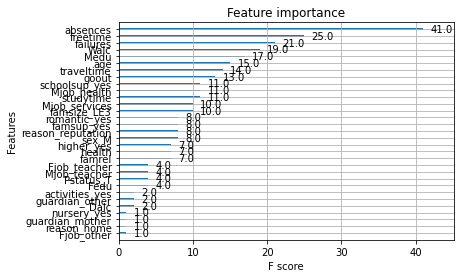

In [90]:
xgb_best = reg.best_estimator_
xgboost.plot_importance(xgb_best)

This doesn't give an improvement over bagging. Maybe I need to improve my understanding of XGBoost. It does give some differences in terms of feature importance though. In particular 'freetime' seems to be important. This refers to free time after school. Let's now look at the distribution of absences, freetime and failures in the dataset.

In [91]:
df1.groupby('absences')['G3'].mean()

absences
0      8.443478
1     13.000000
2     11.907692
3     11.500000
4     11.283019
5     11.600000
6     11.774194
7     11.857143
8     10.590909
9     13.333333
10    11.235294
11    11.666667
12    10.750000
13    12.666667
14     9.333333
15     8.333333
16     9.857143
17    10.000000
18     8.400000
19    10.000000
20    11.500000
21    18.000000
22     8.000000
23    13.000000
24    18.000000
25    11.000000
26     6.000000
28     9.000000
30     8.000000
38     8.000000
40    11.000000
54    11.000000
56     8.000000
75     9.000000
Name: G3, dtype: float64

We can see immediately that people who were never absent get a low score.

In [92]:
df1.groupby('freetime')['G3'].mean()

freetime
1     9.842105
2    11.562500
3     9.783439
4    10.426087
5    11.300000
Name: G3, dtype: float64

'freetime' doesn't seem to yield any significant insight, maybe it is an overfit by the XGBoost regressor.

In [93]:
df1.groupby('failures')['G3'].mean()

failures
0    11.253205
1     8.120000
2     6.235294
3     5.687500
Name: G3, dtype: float64

Finally, higher number of failures in class clearly leads to lower scores.